## Goal: evaluate the relevance of different factors in causing asthma in NYC.

Method:
work on the ZIP code level.

1. Identify the 5 facilities that reported the highest incidence of asthma cases and find which ZIP code they fall in.

2. Develop a Metric for each of the fllowing: access to green space, murder rate, environmental health, and proximity to highways for each ZIP code (no panic, suggestions on how to proceed are in the hints file). You must choose AT LEAST 2 variables among these 4. We encourage you to work with three. Choosing 4 or more, and coming up with additional ones, is considered extra credit.

3. Show a table containing the value of each variable of interest for the 5 ZIP codes corresponding to the highest cases of Asthma.

4. Display each of your metrics as a choropleth (a heatmap version of a geographical map where each zip code is a different color based on the value of the metric you are mapping).

5. Fit a model (try a multivariable linear model for example or any other model which you think may be reasonable, keeping in mind you will need to use the model in the last task) to the incidence of asthma cases per NYC ZIP code (this is your dependent variable) as a function of variables mentioned above, based on the ZIP codes of the top 5 facilities reporing asthma.

6. Cluster the ZIP codes using the model you generated in step 4 as a distance metric (suggestions if needed are in the hints file).

7. Discuss. What did you find? What is the spatial coherence of the different factors considered, which variables seem to be more important in triggering asthma cases, what are the weaknesses of the model, how does the clustering look.

In [110]:
__author__ = "me"
__date__ = "2015_10_13"

%pylab inline
import pandas as pd
import numpy as np
import geopandas as gpd
import mplleaflet

import pylab as plt
import os
import pysal

import requests
from cStringIO import StringIO
try:
    s= requests.get("https://raw.githubusercontent.com/Casyfill/CUSP_templates/master/Py/fbMatplotlibrc.json").json()
    plt.rcParams.update(s)
    
except: 
    pass

try:
    from palettable.cubehelix import  red_16
    mycolormap = red_16.mpl_colormap
except:
    mycolormap ='Blues'

PWD = os.getenv('PWD')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## SQL Helper

In [2]:
def myQueryCartoDB(query='SELECT * FROM nyc_discharge_2013 LIMIT 3', user='htv210', rFormat="CSV"):
    
    source = 'http://{user}.cartodb.com/api/v2/sql'.format(user = user)
    
    params = { 'q':query, 
                'format':rFormat}
    
    r = requests.get(source, params = params)
    r.raise_for_status()
    
    
    if rFormat == 'CSV':
        return pd.read_csv(StringIO(r.content))
    elif rFormat =='GeoJSON':
        return gpd.GeoDataFrame.from_features(r.json()['features'])
    else:
        print 'unknown format'
        
    
    

## QUERIES

In [3]:
dischargeQuery = '''

SELECT facility_id, COUNT(*) AS count 
FROM nyc_discharge_2013  
WHERE lower(ccs_diagnosis_description) LIKE '%asthma%' 
GROUP BY facility_id
ORDER BY count DESC
LIMIT 5;
'''

testQuery = 'SELECT * FROM nyc_discharge_2013  LIMIT 20'

# TASK I

In [117]:
myQueryCartoDB(testQuery).columns

Index([u'cartodb_id', u'the_geom', u'the_geom_webmercator', u'hospital_county',
       u'operating_certificate_number', u'facility_id', u'age_group',
       u'zip_code___3_digits', u'gender', u'race', u'ethnicity',
       u'length_of_stay', u'admit_day_of_week', u'type_of_admission',
       u'patient_disposition', u'discharge_year', u'discharge_day_of_week',
       u'ccs_diagnosis_code', u'ccs_diagnosis_description'],
      dtype='object')

In [118]:
facilities = myQueryCartoDB(query=dischargeQuery)

In [119]:
facilities

,facility_id,count
0,1172,1878
1,1169,1786
2,1301,1057
3,1165,920
4,1178,890


In [120]:
topID = str(tuple(facilities.facility_id.tolist()))

facilityQuery = '''SELECT * FROM nyc_facilities WHERE facility_id in %s''' % topID

print facilityQuery

SELECT * FROM nyc_facilities WHERE facility_id in (1172, 1169, 1301, 1165, 1178)


In [121]:
allFacilities =  myQueryCartoDB(query=facilityQuery, rFormat='GeoJSON')

In [122]:
allFacilities[['facility_id','facility_name']].head()

,facility_id,facility_name
0,1165,Jacobi Medical Center
1,1169,Montefiore Medical Center - Henry & Lucy Moses...
2,1172,Lincoln Medical & Mental Health Center
3,1178,Bronx-Lebanon Hospital Center - Concourse Divi...
4,1301,Kings County Hospital Center


In [123]:
allFacilities.columns

Index([                  u'cartodb_id',           u'cooperator_address',
               u'cooperator_address_2',              u'cooperator_city',
                    u'cooperator_name',             u'cooperator_state',
                u'cooperator_zip_code',                  u'description',
                 u'facility_address_1',           u'facility_address_2',
                      u'facility_city',              u'facility_county',
               u'facility_county_code',          u'facility_fax_number',
                        u'facility_id',            u'facility_latitude',
                  u'facility_location',           u'facility_longitude',
                      u'facility_name',           u'facility_open_date',
              u'facility_phone_number',               u'facility_state',
                   u'facility_website',            u'facility_zip_code',
                           u'geometry',        u'main_site_facility_id',
                     u'main_site_name', u'operating

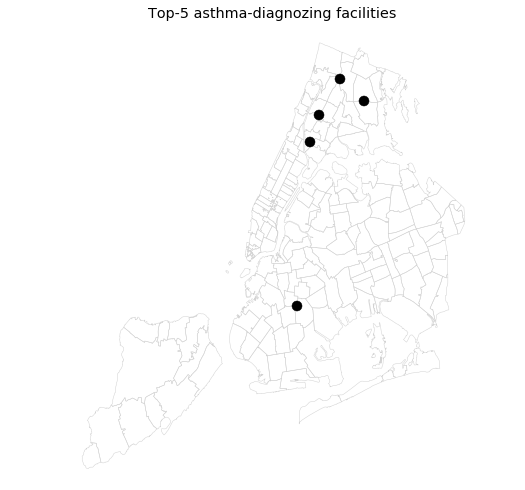

In [124]:
#  OPTIONAL
try:
    zips = gpd.read_file(PWD + '/data/ZIP_CODE_040114/ZIP_CODE_040114.shp')
    allFacilities.crs = {'init': 'epsg:4326', 'no_defs': True}
    allFacilities.to_crs(zips.crs, inplace=1)

    fig,ax = plt.subplots(figsize=(8,8))

    zips.plot(ax=ax, alpha=0, linewidth=.5, edgecolor='lightgrey') ## very slow to plot on sloppy maps

    allFacilities.plot(ax=ax, markersize=10, color='k')
    ax.set_axis_off()
    ax.set_title('Top-5 asthma-diagnozing facilities')
    
except Exception, e:
    print str(e)
    pass

In [126]:
fig,ax = plt.subplots(figsize=(6,6))

# zips.plot(ax=ax, alpha=0) ## very slow to plot on sloppy maps

allFacilities.plot(ax=ax, markersize=10, color='k')
ax.set_axis_off()

mplleaflet.display(fig = fig, crs=allFacilities.crs, tiles='cartodb_positron')

# II. Hightway lenghts

In [127]:
zipcodes

'(10461, 10467, 10451, 10457, 11203)'

In [128]:
zipcodes = str(tuple(allFacilities.facility_zip_code.tolist()))

hightwayQuery = '''SELECT * FROM nyc_zipcode_highway WHERE zipcode in %s''' % zipcodes
hightwayAllQuery = '''SELECT * FROM nyc_zipcode_highway'''

In [129]:
ourZips =  myQueryCartoDB(query=hightwayQuery, rFormat='GeoJSON')
allZips =  myQueryCartoDB(query=hightwayAllQuery, rFormat='GeoJSON')

In [130]:
ourZips

,cartodb_id,geometry,highway_length,zipcode
0,106,"(POLYGON ((-73.863293 40.89529, -73.862875 40....",19.172015,10467
1,111,"(POLYGON ((-73.931681 40.807955, -73.931704 40...",7.914185,10451
2,123,"(POLYGON ((-73.897516 40.856183, -73.896533000...",5.017199,10457
3,125,"(POLYGON ((-73.82612399999999 40.834214, -73.8...",18.102258,10461
4,195,"(POLYGON ((-73.942503 40.638965, -73.943986 40...",2.212840,11203


In [131]:
ourZips.crs = {'init': 'epsg:4326', 'no_defs': True}
allZips.crs = {'init': 'epsg:4326', 'no_defs': True}

ourZips.to_crs(zips.crs, inplace=1)
allZips.to_crs(zips.crs, inplace=1)

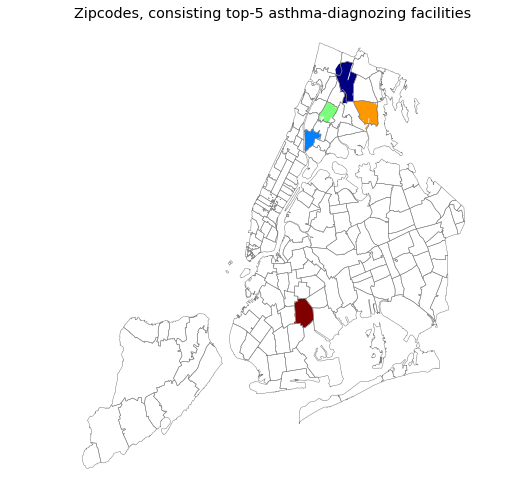

In [132]:
fig,ax = plt.subplots(figsize=(8,8))

ourZips.plot(ax=ax, alpha=1, linewidth=0)
zips.plot(ax=ax, alpha=0, linewidth=.5, edgecolor='grey') ## very slow to plot on sloppy maps

ax.set_axis_off()
ax.set_title('Zipcodes, consisting top-5 asthma-diagnozing facilities')
# mplleaflet.display(fig = fig, crs=allFacilities.crs, tiles='cartodb_positron')

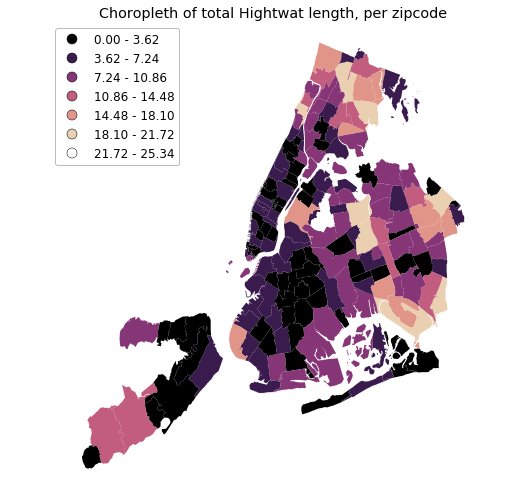

In [134]:
fig,ax = plt.subplots(figsize=(8,8))

allZips.plot(column='highway_length', linewidth=0, 
             alpha=1, cmap=mycolormap, ax=ax, 
             legend=True, scheme='equal_interval', k=7)

ax.set_title('Choropleth of total Hightwat length, per zipcode')
ax.set_axis_off()